# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 46kB/s  eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

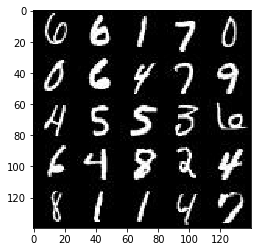

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

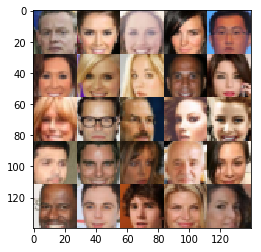

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [13]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, shape=[None, z_dim], name='input_z')
    learn_rate = tf.placeholder(tf.float32, [], 'learn_rate')

    return input_real, input_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [14]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.1
    with tf.variable_scope('discriminator', reuse = reuse):
        conv_layer_1 = tf.layers.conv2d(images, 56, 5, 2, 'SAME')
        conv_layer_1 = tf.maximum(alpha * conv_layer_1, conv_layer_1)
        
        conv_layer_2 = tf.layers.conv2d(conv_layer_1, 112, 5, 2, 'SAME')
        conv_layer_2 = tf.layers.batch_normalization(conv_layer_2, training = True)
        conv_layer_2 = tf.maximum(alpha * conv_layer_2, conv_layer_2)
        
        conv_layer_3 = tf.layers.conv2d(conv_layer_2, 224, 5, 2, 'SAME')
        conv_layer_3 = tf.layers.batch_normalization(conv_layer_3, training = True)
        conv_layer_3 = tf.maximum(alpha * conv_layer_3, conv_layer_3)
        
        flatten_layer = tf.reshape(conv_layer_3, (-1, 4 * 4 * 224))
        logits = tf.layers.dense(flatten_layer, 1)
        logits = tf.layers.dropout(logits, rate=0.25)
        
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [16]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1
    with tf.variable_scope('generator', reuse = not(is_train)):
        dense_layer = tf.layers.dense(z, 7 * 7 * 112)
        dense_layer = tf.reshape(dense_layer, (-1, 7, 7, 112))
        dense_layer = tf.layers.batch_normalization(dense_layer, training = is_train)
        dense_layer = tf.maximum(alpha * dense_layer, dense_layer)
        
        conv_layer_1 = tf.layers.conv2d_transpose(dense_layer, 56, 5, 2, 'SAME')
        conv_layer_1 = tf.layers.batch_normalization(conv_layer_1, training = is_train)
        conv_layer_1 = tf.maximum(alpha * conv_layer_1, conv_layer_1)
        
        conv_layer_2 = tf.layers.conv2d_transpose(conv_layer_1, out_channel_dim, 5, 2, 'SAME')
        output = tf.tanh(conv_layer_2)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [21]:
import numpy as np

def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    generator_model = generator(input_z, out_channel_dim)
    discriminator_model_real, discriminator_logits_real = discriminator(input_real)
    discriminator_model_fake, discriminator_logits_fake = discriminator(generator_model, True)
    discriminator_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_real, 
                                                labels=tf.ones_like(discriminator_logits_real) 
                                                * np.random.uniform(0.7, 1.2)))
    discriminator_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_fake,
                                                labels=tf.zeros_like(discriminator_logits_fake)
                                                * np.random.uniform(0.0, 0.3)))
    discriminator_loss = discriminator_loss_real + discriminator_loss_fake
    generator_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_fake,
                                                labels=tf.ones_like(discriminator_model_fake)))
    
    return discriminator_loss, generator_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [23]:
def model_opt(discriminator_loss, generator_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    trainable_vars = tf.trainable_variables()
    discriminator_vars = [var for var in trainable_vars if var.name.startswith('discriminator')]
    generator_vars = [var for var in trainable_vars if var.name.startswith('generator')]
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        discriminator_train_opt = tf.train.AdamOptimizer(learning_rate,
                                                         beta1=beta1).minimize(discriminator_loss,
                                                                               var_list=discriminator_vars)
        generator_train_opt = tf.train.AdamOptimizer(learning_rate,
                                                     beta1=beta1).minimize(generator_loss,
                                                                           var_list=generator_vars)
    
    return discriminator_train_opt, generator_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [24]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [32]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    discriminator_loss, generator_loss = model_loss(input_real, input_z, data_shape[3])
    discriminator_opt, generator_opt = model_opt(discriminator_loss, generator_loss, learn_rate, beta1)

    print_at = 20
    show_at = 100
    training_steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                training_steps += 1
                batch_images = batch_images * 2
                batch_z_data = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                sess.run(discriminator_opt,
                         feed_dict={input_real: batch_images, input_z: batch_z_data, learn_rate: learning_rate})
                sess.run(generator_opt,
                         feed_dict={input_real: batch_images, input_z: batch_z_data, learn_rate: learning_rate})
                if training_steps % print_at == 0:
                    train_loss_discriminator = discriminator_loss.eval(
                        feed_dict={input_z: batch_z_data, input_real: batch_images})
                    train_loss_generator = generator_loss.eval(
                        feed_dict={input_z: batch_z_data})
                    print("Epoch: {}/{} ".format(epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:.4f}  ".format(train_loss_discriminator),
                          "Generator Loss: {:.4f}   ".format(train_loss_generator))

                if training_steps % show_at == 0:
                    show_generator_output(sess, batch_size, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch: 1/2  Discriminator Loss: 3.0120   Generator Loss: 3.8220   
Epoch: 1/2  Discriminator Loss: 1.4823   Generator Loss: 1.9174   
Epoch: 1/2  Discriminator Loss: 1.1921   Generator Loss: 0.8796   
Epoch: 1/2  Discriminator Loss: 1.4987   Generator Loss: 1.7026   
Epoch: 1/2  Discriminator Loss: 1.3422   Generator Loss: 1.3505   


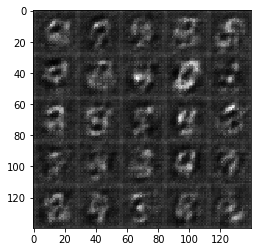

Epoch: 1/2  Discriminator Loss: 1.1380   Generator Loss: 0.6516   
Epoch: 1/2  Discriminator Loss: 1.0053   Generator Loss: 1.4446   
Epoch: 1/2  Discriminator Loss: 1.3472   Generator Loss: 1.5819   
Epoch: 1/2  Discriminator Loss: 2.1083   Generator Loss: 0.1475   
Epoch: 1/2  Discriminator Loss: 0.9945   Generator Loss: 1.1340   


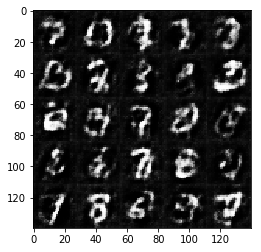

Epoch: 1/2  Discriminator Loss: 1.5292   Generator Loss: 0.3276   
Epoch: 1/2  Discriminator Loss: 1.1069   Generator Loss: 0.6025   
Epoch: 1/2  Discriminator Loss: 2.6423   Generator Loss: 0.1194   
Epoch: 1/2  Discriminator Loss: 1.7279   Generator Loss: 0.2390   
Epoch: 1/2  Discriminator Loss: 1.6849   Generator Loss: 0.2521   


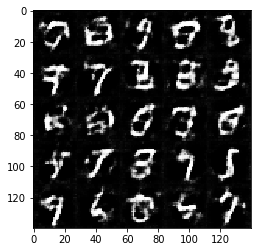

Epoch: 1/2  Discriminator Loss: 1.4550   Generator Loss: 0.3480   
Epoch: 1/2  Discriminator Loss: 1.7997   Generator Loss: 0.2408   
Epoch: 1/2  Discriminator Loss: 2.1096   Generator Loss: 0.1700   
Epoch: 1/2  Discriminator Loss: 1.2550   Generator Loss: 0.4440   
Epoch: 1/2  Discriminator Loss: 1.3302   Generator Loss: 0.3911   


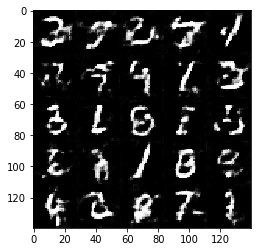

Epoch: 1/2  Discriminator Loss: 0.9620   Generator Loss: 0.9751   
Epoch: 1/2  Discriminator Loss: 1.5668   Generator Loss: 0.2963   
Epoch: 1/2  Discriminator Loss: 1.2091   Generator Loss: 0.4785   
Epoch: 1/2  Discriminator Loss: 1.9047   Generator Loss: 0.2524   
Epoch: 1/2  Discriminator Loss: 1.0326   Generator Loss: 1.4964   


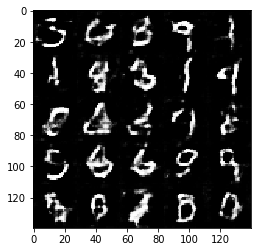

Epoch: 1/2  Discriminator Loss: 0.8833   Generator Loss: 0.7958   
Epoch: 1/2  Discriminator Loss: 1.1904   Generator Loss: 0.5795   
Epoch: 1/2  Discriminator Loss: 1.0480   Generator Loss: 0.8054   
Epoch: 1/2  Discriminator Loss: 1.1655   Generator Loss: 1.9318   
Epoch: 1/2  Discriminator Loss: 1.7910   Generator Loss: 0.2898   


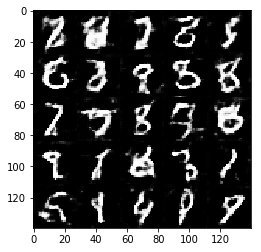

Epoch: 1/2  Discriminator Loss: 2.0946   Generator Loss: 0.1685   
Epoch: 1/2  Discriminator Loss: 1.5973   Generator Loss: 0.3105   
Epoch: 1/2  Discriminator Loss: 1.0768   Generator Loss: 0.5462   
Epoch: 1/2  Discriminator Loss: 1.6015   Generator Loss: 0.2911   
Epoch: 1/2  Discriminator Loss: 1.1582   Generator Loss: 1.8116   


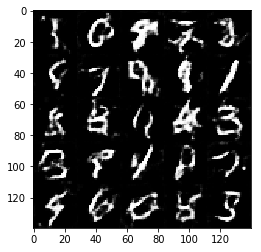

Epoch: 1/2  Discriminator Loss: 0.6422   Generator Loss: 1.9483   
Epoch: 1/2  Discriminator Loss: 1.7654   Generator Loss: 0.2617   
Epoch: 1/2  Discriminator Loss: 2.5974   Generator Loss: 0.1192   
Epoch: 1/2  Discriminator Loss: 0.5479   Generator Loss: 1.5603   
Epoch: 1/2  Discriminator Loss: 1.6961   Generator Loss: 0.3096   


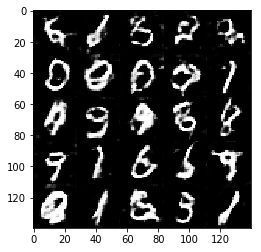

Epoch: 1/2  Discriminator Loss: 0.5734   Generator Loss: 1.4868   
Epoch: 1/2  Discriminator Loss: 2.4308   Generator Loss: 0.1200   
Epoch: 1/2  Discriminator Loss: 0.5528   Generator Loss: 1.2693   
Epoch: 1/2  Discriminator Loss: 1.6564   Generator Loss: 2.8869   
Epoch: 1/2  Discriminator Loss: 1.8448   Generator Loss: 0.2573   


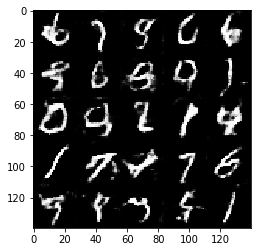

Epoch: 1/2  Discriminator Loss: 0.8584   Generator Loss: 0.7756   
Epoch: 1/2  Discriminator Loss: 1.0079   Generator Loss: 0.6750   
Epoch: 1/2  Discriminator Loss: 0.9053   Generator Loss: 0.7065   
Epoch: 1/2  Discriminator Loss: 1.9402   Generator Loss: 0.2166   
Epoch: 1/2  Discriminator Loss: 2.8831   Generator Loss: 0.1431   


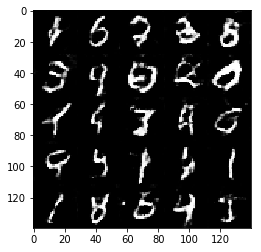

Epoch: 1/2  Discriminator Loss: 0.8255   Generator Loss: 0.9512   
Epoch: 1/2  Discriminator Loss: 1.0715   Generator Loss: 2.2455   
Epoch: 1/2  Discriminator Loss: 1.8575   Generator Loss: 0.3834   
Epoch: 1/2  Discriminator Loss: 0.9447   Generator Loss: 0.6656   
Epoch: 1/2  Discriminator Loss: 0.9455   Generator Loss: 0.6881   


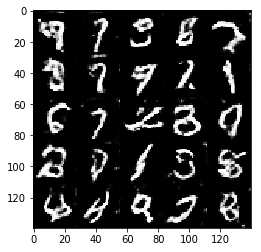

Epoch: 1/2  Discriminator Loss: 0.6765   Generator Loss: 1.0951   
Epoch: 1/2  Discriminator Loss: 1.3439   Generator Loss: 0.4635   
Epoch: 1/2  Discriminator Loss: 1.6888   Generator Loss: 0.3174   
Epoch: 1/2  Discriminator Loss: 0.4862   Generator Loss: 1.9588   
Epoch: 1/2  Discriminator Loss: 1.3197   Generator Loss: 0.5139   


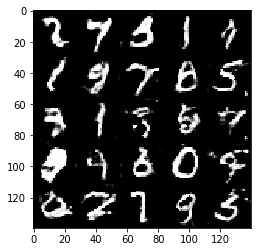

Epoch: 1/2  Discriminator Loss: 0.5720   Generator Loss: 1.2386   
Epoch: 1/2  Discriminator Loss: 1.2213   Generator Loss: 2.9815   
Epoch: 1/2  Discriminator Loss: 2.5846   Generator Loss: 0.1280   
Epoch: 1/2  Discriminator Loss: 0.6454   Generator Loss: 2.2734   
Epoch: 1/2  Discriminator Loss: 0.4737   Generator Loss: 2.0096   


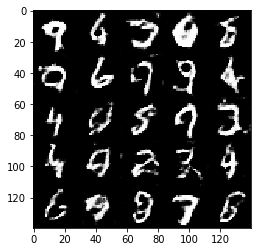

Epoch: 1/2  Discriminator Loss: 1.1930   Generator Loss: 0.4690   
Epoch: 1/2  Discriminator Loss: 0.6860   Generator Loss: 0.9865   
Epoch: 1/2  Discriminator Loss: 0.5584   Generator Loss: 1.9733   
Epoch: 1/2  Discriminator Loss: 4.3922   Generator Loss: 7.5712   
Epoch: 1/2  Discriminator Loss: 0.8561   Generator Loss: 0.8483   


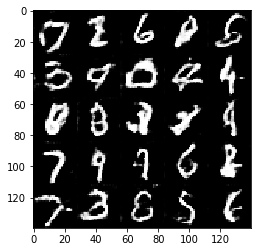

Epoch: 1/2  Discriminator Loss: 0.9198   Generator Loss: 0.7478   
Epoch: 1/2  Discriminator Loss: 0.5149   Generator Loss: 1.5303   
Epoch: 1/2  Discriminator Loss: 2.5355   Generator Loss: 0.1503   
Epoch: 1/2  Discriminator Loss: 2.0446   Generator Loss: 0.2016   
Epoch: 1/2  Discriminator Loss: 1.0792   Generator Loss: 0.6598   


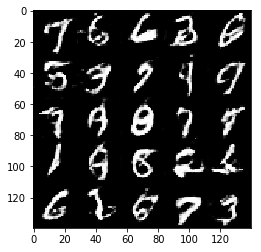

Epoch: 1/2  Discriminator Loss: 0.2408   Generator Loss: 2.1932   
Epoch: 1/2  Discriminator Loss: 0.6684   Generator Loss: 0.9682   
Epoch: 1/2  Discriminator Loss: 1.0721   Generator Loss: 0.7035   
Epoch: 1/2  Discriminator Loss: 0.8779   Generator Loss: 1.1384   
Epoch: 1/2  Discriminator Loss: 0.5629   Generator Loss: 1.9130   


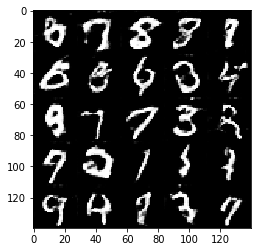

Epoch: 1/2  Discriminator Loss: 0.4251   Generator Loss: 1.6188   
Epoch: 1/2  Discriminator Loss: 0.6469   Generator Loss: 1.0604   
Epoch: 1/2  Discriminator Loss: 0.2907   Generator Loss: 1.9007   
Epoch: 1/2  Discriminator Loss: 0.5324   Generator Loss: 1.4634   
Epoch: 1/2  Discriminator Loss: 0.4160   Generator Loss: 1.4867   


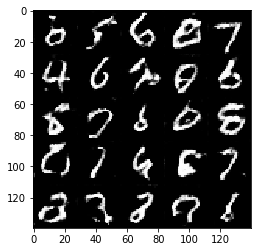

Epoch: 1/2  Discriminator Loss: 1.0806   Generator Loss: 0.6941   
Epoch: 1/2  Discriminator Loss: 1.2361   Generator Loss: 2.9103   
Epoch: 1/2  Discriminator Loss: 0.4834   Generator Loss: 2.0999   
Epoch: 1/2  Discriminator Loss: 1.3607   Generator Loss: 0.4612   
Epoch: 1/2  Discriminator Loss: 1.3432   Generator Loss: 3.8191   


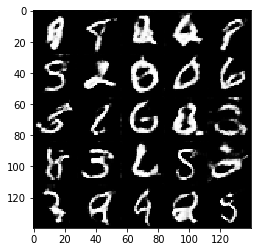

Epoch: 1/2  Discriminator Loss: 2.3794   Generator Loss: 5.1219   
Epoch: 1/2  Discriminator Loss: 0.9288   Generator Loss: 0.7159   
Epoch: 1/2  Discriminator Loss: 0.7819   Generator Loss: 1.1592   
Epoch: 2/2  Discriminator Loss: 0.4328   Generator Loss: 1.4620   
Epoch: 2/2  Discriminator Loss: 0.6345   Generator Loss: 1.1233   


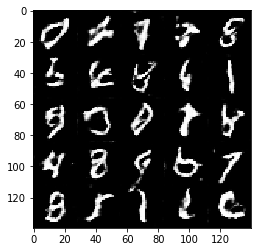

Epoch: 2/2  Discriminator Loss: 0.5949   Generator Loss: 1.6721   
Epoch: 2/2  Discriminator Loss: 1.8648   Generator Loss: 0.2112   
Epoch: 2/2  Discriminator Loss: 0.4265   Generator Loss: 2.4514   
Epoch: 2/2  Discriminator Loss: 1.1715   Generator Loss: 0.6675   
Epoch: 2/2  Discriminator Loss: 0.3460   Generator Loss: 2.6225   


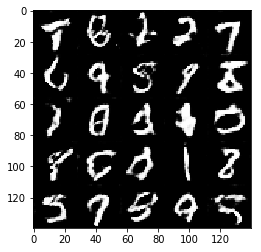

Epoch: 2/2  Discriminator Loss: 0.4504   Generator Loss: 1.5991   
Epoch: 2/2  Discriminator Loss: 0.3585   Generator Loss: 1.6354   
Epoch: 2/2  Discriminator Loss: 3.1205   Generator Loss: 0.0914   
Epoch: 2/2  Discriminator Loss: 3.1546   Generator Loss: 0.0916   
Epoch: 2/2  Discriminator Loss: 0.9938   Generator Loss: 0.6645   


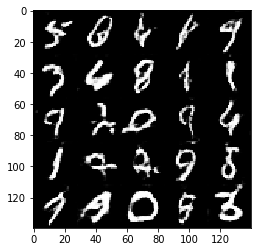

Epoch: 2/2  Discriminator Loss: 1.1413   Generator Loss: 0.6100   
Epoch: 2/2  Discriminator Loss: 2.6429   Generator Loss: 0.1282   
Epoch: 2/2  Discriminator Loss: 0.5864   Generator Loss: 3.4686   
Epoch: 2/2  Discriminator Loss: 1.0270   Generator Loss: 0.6705   
Epoch: 2/2  Discriminator Loss: 0.6577   Generator Loss: 1.0446   


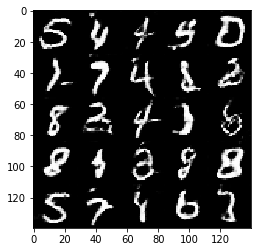

Epoch: 2/2  Discriminator Loss: 0.7297   Generator Loss: 1.0269   
Epoch: 2/2  Discriminator Loss: 3.3607   Generator Loss: 0.0757   
Epoch: 2/2  Discriminator Loss: 0.8406   Generator Loss: 0.9282   
Epoch: 2/2  Discriminator Loss: 2.0805   Generator Loss: 0.2466   
Epoch: 2/2  Discriminator Loss: 0.6522   Generator Loss: 1.1715   


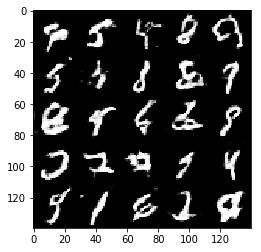

Epoch: 2/2  Discriminator Loss: 0.7327   Generator Loss: 1.0622   
Epoch: 2/2  Discriminator Loss: 1.1209   Generator Loss: 0.7873   
Epoch: 2/2  Discriminator Loss: 1.1217   Generator Loss: 0.6201   
Epoch: 2/2  Discriminator Loss: 0.4262   Generator Loss: 1.8442   
Epoch: 2/2  Discriminator Loss: 0.5432   Generator Loss: 1.3409   


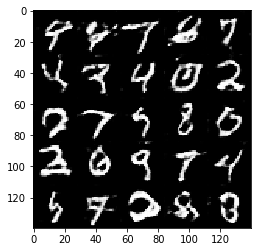

Epoch: 2/2  Discriminator Loss: 1.2110   Generator Loss: 0.5986   
Epoch: 2/2  Discriminator Loss: 0.3486   Generator Loss: 1.9697   
Epoch: 2/2  Discriminator Loss: 0.4057   Generator Loss: 1.6492   
Epoch: 2/2  Discriminator Loss: 0.3986   Generator Loss: 1.7062   
Epoch: 2/2  Discriminator Loss: 1.9151   Generator Loss: 0.2476   


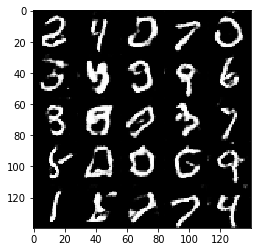

Epoch: 2/2  Discriminator Loss: 0.9115   Generator Loss: 0.8988   
Epoch: 2/2  Discriminator Loss: 0.4549   Generator Loss: 1.4828   
Epoch: 2/2  Discriminator Loss: 1.0578   Generator Loss: 0.5661   
Epoch: 2/2  Discriminator Loss: 0.7705   Generator Loss: 1.0898   
Epoch: 2/2  Discriminator Loss: 0.6615   Generator Loss: 1.2027   


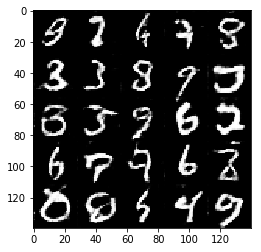

Epoch: 2/2  Discriminator Loss: 1.1721   Generator Loss: 0.6176   
Epoch: 2/2  Discriminator Loss: 0.7638   Generator Loss: 0.8810   
Epoch: 2/2  Discriminator Loss: 0.9986   Generator Loss: 0.7394   
Epoch: 2/2  Discriminator Loss: 0.8135   Generator Loss: 2.6230   
Epoch: 2/2  Discriminator Loss: 1.9166   Generator Loss: 0.2086   


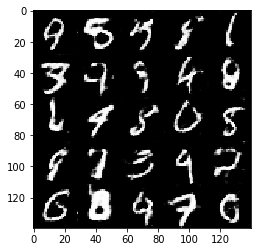

Epoch: 2/2  Discriminator Loss: 0.4584   Generator Loss: 1.5074   
Epoch: 2/2  Discriminator Loss: 0.7100   Generator Loss: 3.2270   
Epoch: 2/2  Discriminator Loss: 1.0082   Generator Loss: 0.6628   
Epoch: 2/2  Discriminator Loss: 0.6405   Generator Loss: 1.0634   
Epoch: 2/2  Discriminator Loss: 0.9024   Generator Loss: 0.9106   


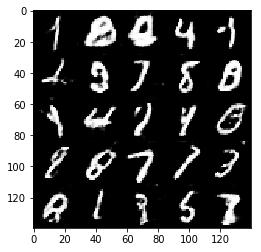

Epoch: 2/2  Discriminator Loss: 0.7376   Generator Loss: 0.9539   
Epoch: 2/2  Discriminator Loss: 0.6349   Generator Loss: 0.9798   
Epoch: 2/2  Discriminator Loss: 0.9088   Generator Loss: 0.8670   
Epoch: 2/2  Discriminator Loss: 0.8228   Generator Loss: 0.7966   
Epoch: 2/2  Discriminator Loss: 0.3950   Generator Loss: 1.4965   


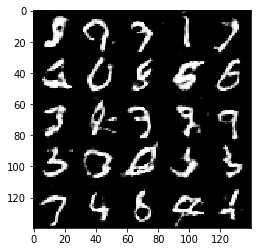

Epoch: 2/2  Discriminator Loss: 0.4115   Generator Loss: 1.4059   
Epoch: 2/2  Discriminator Loss: 0.5256   Generator Loss: 1.2326   
Epoch: 2/2  Discriminator Loss: 0.8043   Generator Loss: 4.1814   
Epoch: 2/2  Discriminator Loss: 1.0091   Generator Loss: 0.6176   
Epoch: 2/2  Discriminator Loss: 0.6032   Generator Loss: 1.3028   


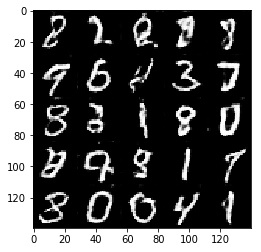

Epoch: 2/2  Discriminator Loss: 1.3898   Generator Loss: 0.5716   
Epoch: 2/2  Discriminator Loss: 1.3423   Generator Loss: 0.5197   
Epoch: 2/2  Discriminator Loss: 1.9255   Generator Loss: 0.4289   
Epoch: 2/2  Discriminator Loss: 0.7841   Generator Loss: 1.0329   
Epoch: 2/2  Discriminator Loss: 0.6309   Generator Loss: 1.1721   


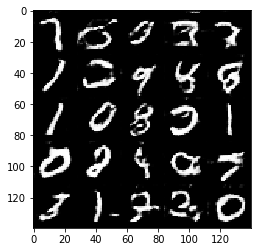

Epoch: 2/2  Discriminator Loss: 0.8622   Generator Loss: 0.8535   
Epoch: 2/2  Discriminator Loss: 0.5030   Generator Loss: 1.2664   
Epoch: 2/2  Discriminator Loss: 0.7388   Generator Loss: 1.0289   
Epoch: 2/2  Discriminator Loss: 0.7617   Generator Loss: 1.1479   
Epoch: 2/2  Discriminator Loss: 0.6423   Generator Loss: 1.0460   


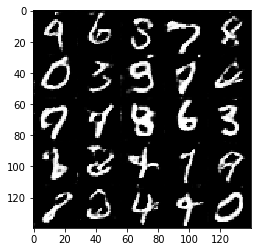

Epoch: 2/2  Discriminator Loss: 0.2990   Generator Loss: 1.8959   
Epoch: 2/2  Discriminator Loss: 1.3923   Generator Loss: 0.5093   
Epoch: 2/2  Discriminator Loss: 0.6948   Generator Loss: 4.5708   
Epoch: 2/2  Discriminator Loss: 0.9823   Generator Loss: 0.8286   
Epoch: 2/2  Discriminator Loss: 1.8412   Generator Loss: 0.2939   


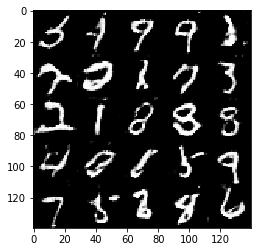

Epoch: 2/2  Discriminator Loss: 0.8677   Generator Loss: 1.0962   
Epoch: 2/2  Discriminator Loss: 1.6929   Generator Loss: 0.3898   
Epoch: 2/2  Discriminator Loss: 2.6348   Generator Loss: 0.1864   
Epoch: 2/2  Discriminator Loss: 0.7442   Generator Loss: 0.9198   
Epoch: 2/2  Discriminator Loss: 0.8751   Generator Loss: 0.8143   


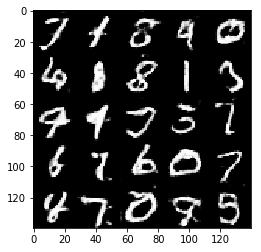

Epoch: 2/2  Discriminator Loss: 0.3879   Generator Loss: 2.0214   
Epoch: 2/2  Discriminator Loss: 0.7196   Generator Loss: 0.9789   
Epoch: 2/2  Discriminator Loss: 0.5289   Generator Loss: 1.4486   
Epoch: 2/2  Discriminator Loss: 0.8364   Generator Loss: 0.8951   
Epoch: 2/2  Discriminator Loss: 0.7983   Generator Loss: 0.9858   


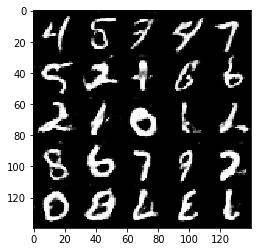

Epoch: 2/2  Discriminator Loss: 0.5823   Generator Loss: 1.3336   
Epoch: 2/2  Discriminator Loss: 1.2639   Generator Loss: 0.5673   
Epoch: 2/2  Discriminator Loss: 0.6588   Generator Loss: 1.0943   
Epoch: 2/2  Discriminator Loss: 0.5600   Generator Loss: 1.1140   
Epoch: 2/2  Discriminator Loss: 0.5320   Generator Loss: 1.3337   


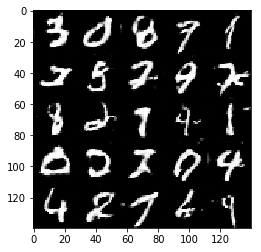

Epoch: 2/2  Discriminator Loss: 0.5008   Generator Loss: 1.5986   
Epoch: 2/2  Discriminator Loss: 0.7492   Generator Loss: 1.1432   
Epoch: 2/2  Discriminator Loss: 0.2629   Generator Loss: 1.9779   
Epoch: 2/2  Discriminator Loss: 0.2918   Generator Loss: 3.3538   
Epoch: 2/2  Discriminator Loss: 0.7813   Generator Loss: 0.8831   


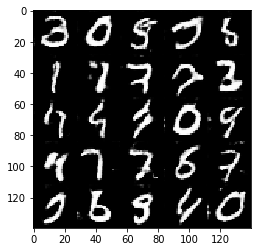

Epoch: 2/2  Discriminator Loss: 0.7948   Generator Loss: 1.2001   
Epoch: 2/2  Discriminator Loss: 1.1007   Generator Loss: 0.6429   


In [33]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch: 1/1  Discriminator Loss: 5.1754   Generator Loss: 0.0161   
Epoch: 1/1  Discriminator Loss: 1.2476   Generator Loss: 0.5585   
Epoch: 1/1  Discriminator Loss: 0.8190   Generator Loss: 1.4694   
Epoch: 1/1  Discriminator Loss: 1.4436   Generator Loss: 1.4036   
Epoch: 1/1  Discriminator Loss: 1.5638   Generator Loss: 0.5877   


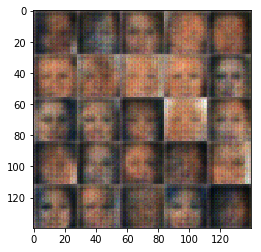

Epoch: 1/1  Discriminator Loss: 1.7312   Generator Loss: 0.3162   
Epoch: 1/1  Discriminator Loss: 1.1202   Generator Loss: 0.7679   
Epoch: 1/1  Discriminator Loss: 1.4573   Generator Loss: 0.4517   
Epoch: 1/1  Discriminator Loss: 1.4349   Generator Loss: 1.5533   
Epoch: 1/1  Discriminator Loss: 1.6491   Generator Loss: 0.3925   


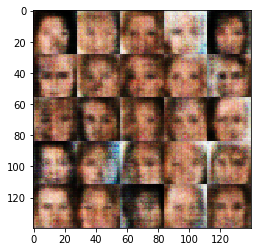

Epoch: 1/1  Discriminator Loss: 1.2812   Generator Loss: 0.5371   
Epoch: 1/1  Discriminator Loss: 1.9285   Generator Loss: 0.2619   
Epoch: 1/1  Discriminator Loss: 1.4239   Generator Loss: 0.6047   
Epoch: 1/1  Discriminator Loss: 1.5136   Generator Loss: 1.9107   
Epoch: 1/1  Discriminator Loss: 1.3506   Generator Loss: 1.3824   


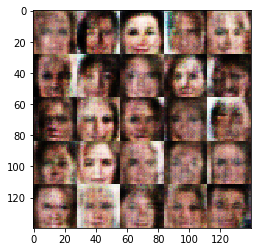

Epoch: 1/1  Discriminator Loss: 1.2094   Generator Loss: 0.8233   
Epoch: 1/1  Discriminator Loss: 1.2166   Generator Loss: 0.7543   
Epoch: 1/1  Discriminator Loss: 1.7761   Generator Loss: 1.5482   
Epoch: 1/1  Discriminator Loss: 1.1277   Generator Loss: 0.7030   
Epoch: 1/1  Discriminator Loss: 1.3921   Generator Loss: 0.9473   


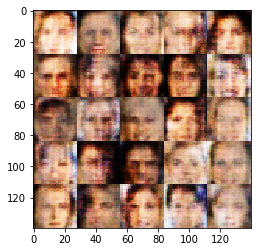

Epoch: 1/1  Discriminator Loss: 1.3424   Generator Loss: 0.6331   
Epoch: 1/1  Discriminator Loss: 1.1001   Generator Loss: 0.7049   
Epoch: 1/1  Discriminator Loss: 1.1987   Generator Loss: 0.7393   
Epoch: 1/1  Discriminator Loss: 0.8448   Generator Loss: 1.2264   
Epoch: 1/1  Discriminator Loss: 1.1588   Generator Loss: 1.4680   


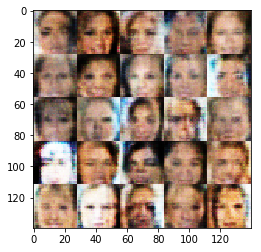

Epoch: 1/1  Discriminator Loss: 1.5351   Generator Loss: 1.1172   
Epoch: 1/1  Discriminator Loss: 1.8917   Generator Loss: 2.4349   
Epoch: 1/1  Discriminator Loss: 1.3999   Generator Loss: 0.7099   
Epoch: 1/1  Discriminator Loss: 1.1476   Generator Loss: 0.6442   
Epoch: 1/1  Discriminator Loss: 1.4855   Generator Loss: 0.5238   


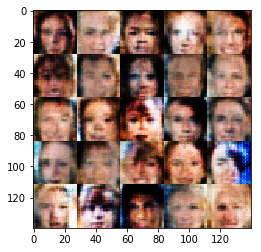

Epoch: 1/1  Discriminator Loss: 0.8768   Generator Loss: 1.0041   
Epoch: 1/1  Discriminator Loss: 1.4592   Generator Loss: 0.5565   
Epoch: 1/1  Discriminator Loss: 1.3960   Generator Loss: 0.8951   
Epoch: 1/1  Discriminator Loss: 1.5334   Generator Loss: 0.5323   
Epoch: 1/1  Discriminator Loss: 1.3506   Generator Loss: 0.9342   


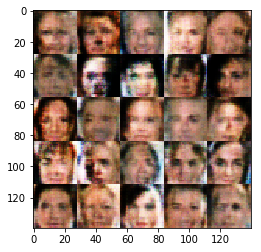

Epoch: 1/1  Discriminator Loss: 1.2089   Generator Loss: 1.6304   
Epoch: 1/1  Discriminator Loss: 1.3008   Generator Loss: 0.6072   
Epoch: 1/1  Discriminator Loss: 1.3400   Generator Loss: 0.7551   
Epoch: 1/1  Discriminator Loss: 1.2076   Generator Loss: 0.7989   
Epoch: 1/1  Discriminator Loss: 1.6105   Generator Loss: 1.8864   


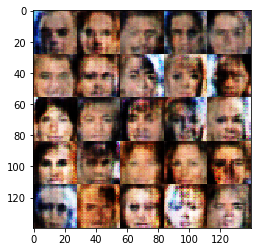

Epoch: 1/1  Discriminator Loss: 0.8545   Generator Loss: 0.9292   
Epoch: 1/1  Discriminator Loss: 1.3532   Generator Loss: 0.6372   
Epoch: 1/1  Discriminator Loss: 1.2142   Generator Loss: 0.6196   
Epoch: 1/1  Discriminator Loss: 1.3727   Generator Loss: 0.8724   
Epoch: 1/1  Discriminator Loss: 1.7714   Generator Loss: 1.5798   


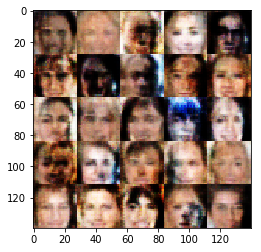

Epoch: 1/1  Discriminator Loss: 1.5154   Generator Loss: 0.3793   
Epoch: 1/1  Discriminator Loss: 1.1399   Generator Loss: 0.7058   
Epoch: 1/1  Discriminator Loss: 1.4392   Generator Loss: 1.5187   
Epoch: 1/1  Discriminator Loss: 0.9898   Generator Loss: 1.0969   
Epoch: 1/1  Discriminator Loss: 2.1187   Generator Loss: 0.2500   


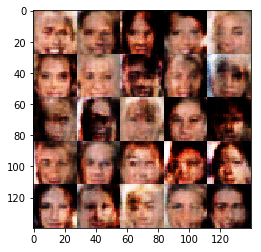

Epoch: 1/1  Discriminator Loss: 1.2589   Generator Loss: 0.6749   
Epoch: 1/1  Discriminator Loss: 1.6178   Generator Loss: 1.7019   
Epoch: 1/1  Discriminator Loss: 3.2820   Generator Loss: 3.2779   
Epoch: 1/1  Discriminator Loss: 1.1787   Generator Loss: 0.9933   
Epoch: 1/1  Discriminator Loss: 1.2857   Generator Loss: 0.8189   


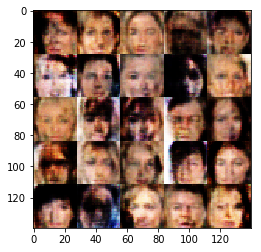

Epoch: 1/1  Discriminator Loss: 1.0282   Generator Loss: 1.0577   
Epoch: 1/1  Discriminator Loss: 1.3853   Generator Loss: 1.0313   
Epoch: 1/1  Discriminator Loss: 1.2592   Generator Loss: 0.9737   
Epoch: 1/1  Discriminator Loss: 1.1657   Generator Loss: 0.9272   
Epoch: 1/1  Discriminator Loss: 1.0883   Generator Loss: 0.8051   


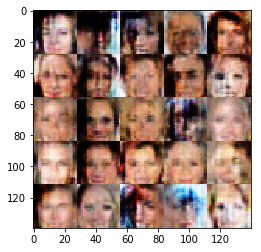

Epoch: 1/1  Discriminator Loss: 1.4301   Generator Loss: 0.6164   
Epoch: 1/1  Discriminator Loss: 1.2783   Generator Loss: 0.6170   
Epoch: 1/1  Discriminator Loss: 1.5731   Generator Loss: 0.4372   
Epoch: 1/1  Discriminator Loss: 1.3550   Generator Loss: 0.6787   
Epoch: 1/1  Discriminator Loss: 0.9005   Generator Loss: 0.9779   


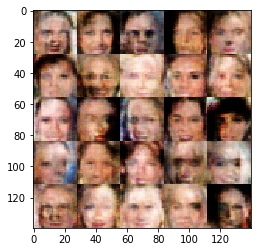

Epoch: 1/1  Discriminator Loss: 0.9133   Generator Loss: 1.0810   
Epoch: 1/1  Discriminator Loss: 1.2307   Generator Loss: 0.9810   
Epoch: 1/1  Discriminator Loss: 1.2955   Generator Loss: 0.7573   
Epoch: 1/1  Discriminator Loss: 1.0537   Generator Loss: 1.3752   
Epoch: 1/1  Discriminator Loss: 1.2745   Generator Loss: 0.5620   


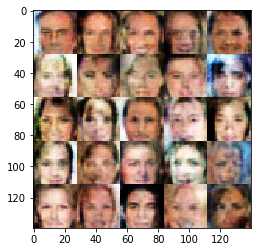

Epoch: 1/1  Discriminator Loss: 1.3217   Generator Loss: 1.6187   
Epoch: 1/1  Discriminator Loss: 0.9444   Generator Loss: 1.3031   
Epoch: 1/1  Discriminator Loss: 1.1876   Generator Loss: 1.2806   
Epoch: 1/1  Discriminator Loss: 1.5346   Generator Loss: 0.3962   
Epoch: 1/1  Discriminator Loss: 2.0240   Generator Loss: 1.5275   


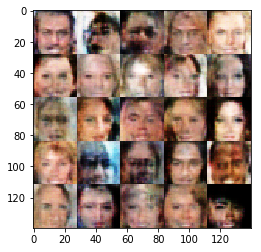

Epoch: 1/1  Discriminator Loss: 1.3565   Generator Loss: 0.9734   
Epoch: 1/1  Discriminator Loss: 1.2547   Generator Loss: 0.6850   
Epoch: 1/1  Discriminator Loss: 1.3904   Generator Loss: 0.6921   
Epoch: 1/1  Discriminator Loss: 1.1739   Generator Loss: 0.7718   
Epoch: 1/1  Discriminator Loss: 1.0629   Generator Loss: 1.1642   


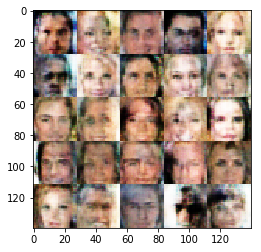

Epoch: 1/1  Discriminator Loss: 1.1502   Generator Loss: 0.8665   
Epoch: 1/1  Discriminator Loss: 1.4035   Generator Loss: 0.4523   
Epoch: 1/1  Discriminator Loss: 1.3471   Generator Loss: 0.5139   
Epoch: 1/1  Discriminator Loss: 1.3157   Generator Loss: 0.6538   
Epoch: 1/1  Discriminator Loss: 1.0619   Generator Loss: 1.1645   


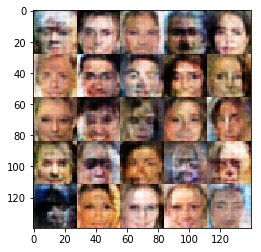

Epoch: 1/1  Discriminator Loss: 1.3420   Generator Loss: 0.5697   
Epoch: 1/1  Discriminator Loss: 1.4784   Generator Loss: 1.2749   
Epoch: 1/1  Discriminator Loss: 1.3904   Generator Loss: 1.7645   
Epoch: 1/1  Discriminator Loss: 1.1790   Generator Loss: 0.7056   
Epoch: 1/1  Discriminator Loss: 1.0565   Generator Loss: 0.9507   


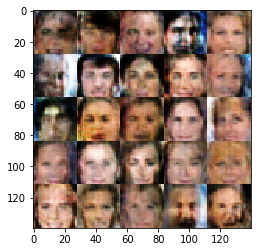

Epoch: 1/1  Discriminator Loss: 1.3252   Generator Loss: 0.6512   
Epoch: 1/1  Discriminator Loss: 1.1108   Generator Loss: 0.7832   
Epoch: 1/1  Discriminator Loss: 1.2199   Generator Loss: 0.7379   
Epoch: 1/1  Discriminator Loss: 1.3904   Generator Loss: 0.4639   
Epoch: 1/1  Discriminator Loss: 1.1955   Generator Loss: 0.8310   


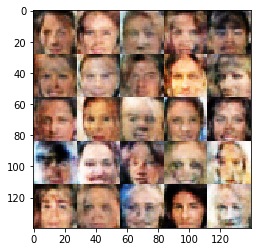

Epoch: 1/1  Discriminator Loss: 1.2682   Generator Loss: 0.8679   
Epoch: 1/1  Discriminator Loss: 1.0130   Generator Loss: 0.9559   
Epoch: 1/1  Discriminator Loss: 2.2052   Generator Loss: 0.1704   
Epoch: 1/1  Discriminator Loss: 1.4079   Generator Loss: 0.4787   
Epoch: 1/1  Discriminator Loss: 1.4899   Generator Loss: 0.4615   


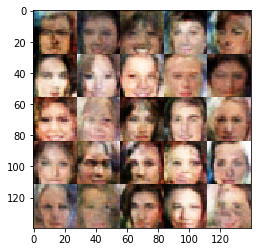

Epoch: 1/1  Discriminator Loss: 1.2468   Generator Loss: 0.7102   
Epoch: 1/1  Discriminator Loss: 1.2487   Generator Loss: 0.7159   
Epoch: 1/1  Discriminator Loss: 1.2971   Generator Loss: 1.2127   
Epoch: 1/1  Discriminator Loss: 1.3498   Generator Loss: 0.8116   
Epoch: 1/1  Discriminator Loss: 1.0368   Generator Loss: 0.8955   


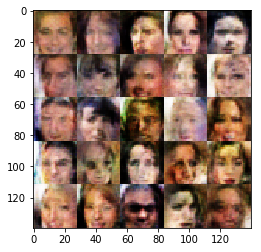

Epoch: 1/1  Discriminator Loss: 0.9602   Generator Loss: 0.9681   
Epoch: 1/1  Discriminator Loss: 1.6924   Generator Loss: 0.3326   
Epoch: 1/1  Discriminator Loss: 1.2527   Generator Loss: 1.0123   
Epoch: 1/1  Discriminator Loss: 1.4224   Generator Loss: 0.4874   
Epoch: 1/1  Discriminator Loss: 1.3555   Generator Loss: 0.5509   


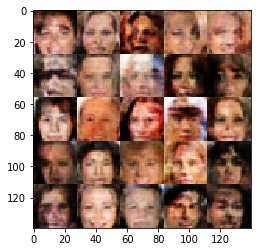

Epoch: 1/1  Discriminator Loss: 1.4492   Generator Loss: 0.4303   
Epoch: 1/1  Discriminator Loss: 1.3585   Generator Loss: 0.5087   
Epoch: 1/1  Discriminator Loss: 1.2421   Generator Loss: 0.6404   
Epoch: 1/1  Discriminator Loss: 1.2173   Generator Loss: 1.8194   
Epoch: 1/1  Discriminator Loss: 1.5868   Generator Loss: 0.3983   


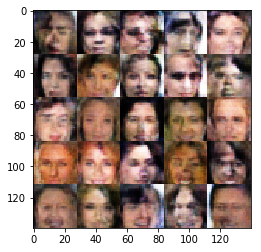

Epoch: 1/1  Discriminator Loss: 1.2034   Generator Loss: 0.8842   
Epoch: 1/1  Discriminator Loss: 1.3838   Generator Loss: 0.4608   
Epoch: 1/1  Discriminator Loss: 1.0691   Generator Loss: 1.0509   
Epoch: 1/1  Discriminator Loss: 1.1538   Generator Loss: 0.9228   
Epoch: 1/1  Discriminator Loss: 1.2306   Generator Loss: 1.2499   


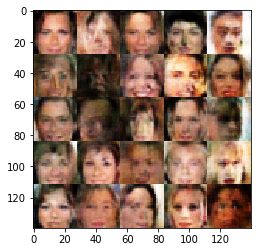

Epoch: 1/1  Discriminator Loss: 0.9181   Generator Loss: 1.2480   
Epoch: 1/1  Discriminator Loss: 1.1213   Generator Loss: 1.0430   
Epoch: 1/1  Discriminator Loss: 1.8392   Generator Loss: 0.2689   
Epoch: 1/1  Discriminator Loss: 1.3587   Generator Loss: 0.4947   
Epoch: 1/1  Discriminator Loss: 1.4857   Generator Loss: 0.4007   


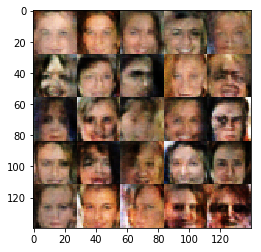

Epoch: 1/1  Discriminator Loss: 1.6005   Generator Loss: 0.3627   
Epoch: 1/1  Discriminator Loss: 1.6539   Generator Loss: 0.3665   
Epoch: 1/1  Discriminator Loss: 1.0686   Generator Loss: 1.1173   
Epoch: 1/1  Discriminator Loss: 1.0476   Generator Loss: 0.8355   
Epoch: 1/1  Discriminator Loss: 1.3441   Generator Loss: 0.5054   


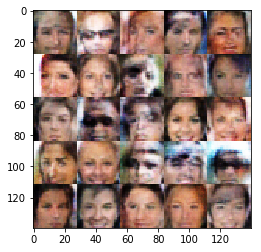

Epoch: 1/1  Discriminator Loss: 1.9655   Generator Loss: 0.2336   
Epoch: 1/1  Discriminator Loss: 1.1115   Generator Loss: 0.7388   
Epoch: 1/1  Discriminator Loss: 1.2412   Generator Loss: 1.5631   
Epoch: 1/1  Discriminator Loss: 1.0320   Generator Loss: 1.3375   
Epoch: 1/1  Discriminator Loss: 1.0374   Generator Loss: 0.7744   


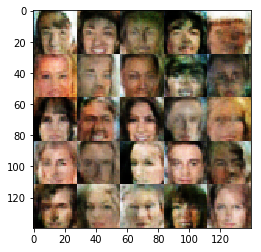

Epoch: 1/1  Discriminator Loss: 1.2304   Generator Loss: 0.8407   
Epoch: 1/1  Discriminator Loss: 2.0231   Generator Loss: 0.2279   
Epoch: 1/1  Discriminator Loss: 1.5657   Generator Loss: 0.4019   
Epoch: 1/1  Discriminator Loss: 1.6822   Generator Loss: 0.3257   
Epoch: 1/1  Discriminator Loss: 1.1072   Generator Loss: 0.7677   


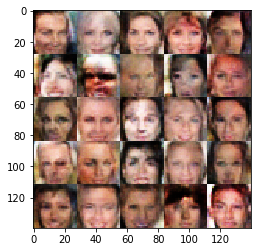

Epoch: 1/1  Discriminator Loss: 1.0926   Generator Loss: 0.8935   
Epoch: 1/1  Discriminator Loss: 1.6444   Generator Loss: 0.3402   
Epoch: 1/1  Discriminator Loss: 1.5807   Generator Loss: 0.4012   
Epoch: 1/1  Discriminator Loss: 0.9292   Generator Loss: 1.0143   
Epoch: 1/1  Discriminator Loss: 0.9395   Generator Loss: 1.4114   


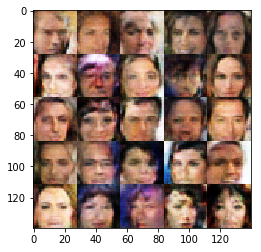

Epoch: 1/1  Discriminator Loss: 1.4579   Generator Loss: 0.8020   
Epoch: 1/1  Discriminator Loss: 1.1295   Generator Loss: 1.1777   
Epoch: 1/1  Discriminator Loss: 1.4427   Generator Loss: 0.4332   
Epoch: 1/1  Discriminator Loss: 1.5342   Generator Loss: 1.0119   
Epoch: 1/1  Discriminator Loss: 1.3487   Generator Loss: 0.9052   


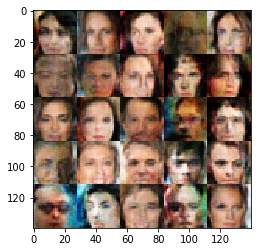

Epoch: 1/1  Discriminator Loss: 1.2084   Generator Loss: 0.6959   
Epoch: 1/1  Discriminator Loss: 1.2255   Generator Loss: 0.7018   
Epoch: 1/1  Discriminator Loss: 1.3010   Generator Loss: 0.6209   
Epoch: 1/1  Discriminator Loss: 1.4892   Generator Loss: 1.6576   
Epoch: 1/1  Discriminator Loss: 1.8986   Generator Loss: 0.2662   


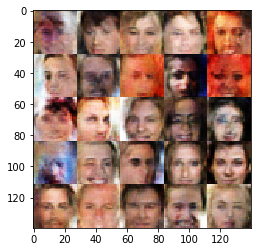

Epoch: 1/1  Discriminator Loss: 1.4410   Generator Loss: 0.4612   
Epoch: 1/1  Discriminator Loss: 1.2088   Generator Loss: 0.8538   
Epoch: 1/1  Discriminator Loss: 1.2279   Generator Loss: 0.8962   
Epoch: 1/1  Discriminator Loss: 1.2996   Generator Loss: 1.3321   
Epoch: 1/1  Discriminator Loss: 1.2579   Generator Loss: 1.1267   


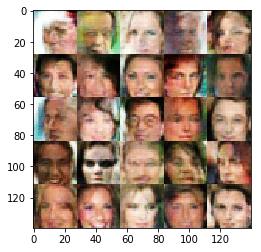

Epoch: 1/1  Discriminator Loss: 1.2580   Generator Loss: 0.6510   
Epoch: 1/1  Discriminator Loss: 1.0644   Generator Loss: 1.1909   
Epoch: 1/1  Discriminator Loss: 1.1897   Generator Loss: 1.6729   
Epoch: 1/1  Discriminator Loss: 0.7133   Generator Loss: 1.3912   
Epoch: 1/1  Discriminator Loss: 1.0604   Generator Loss: 0.9828   


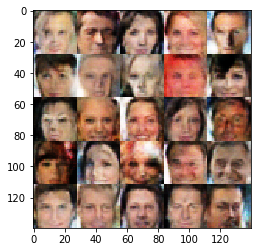

Epoch: 1/1  Discriminator Loss: 1.4828   Generator Loss: 0.4222   
Epoch: 1/1  Discriminator Loss: 1.2669   Generator Loss: 0.5420   
Epoch: 1/1  Discriminator Loss: 1.1302   Generator Loss: 0.8888   
Epoch: 1/1  Discriminator Loss: 1.4781   Generator Loss: 0.4559   
Epoch: 1/1  Discriminator Loss: 1.2860   Generator Loss: 0.5359   


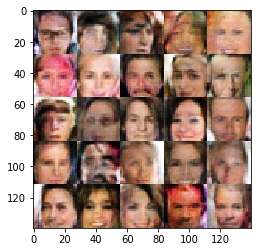

Epoch: 1/1  Discriminator Loss: 1.2844   Generator Loss: 0.6084   
Epoch: 1/1  Discriminator Loss: 1.4878   Generator Loss: 0.4798   
Epoch: 1/1  Discriminator Loss: 1.3684   Generator Loss: 0.8435   
Epoch: 1/1  Discriminator Loss: 1.2373   Generator Loss: 1.1010   
Epoch: 1/1  Discriminator Loss: 1.0946   Generator Loss: 1.0064   


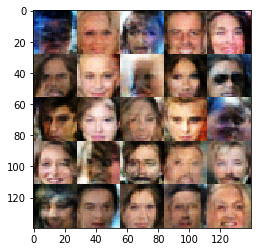

Epoch: 1/1  Discriminator Loss: 1.1406   Generator Loss: 0.9352   
Epoch: 1/1  Discriminator Loss: 1.0934   Generator Loss: 0.8843   
Epoch: 1/1  Discriminator Loss: 1.2113   Generator Loss: 0.6257   
Epoch: 1/1  Discriminator Loss: 1.6960   Generator Loss: 0.3232   
Epoch: 1/1  Discriminator Loss: 1.4191   Generator Loss: 0.4693   


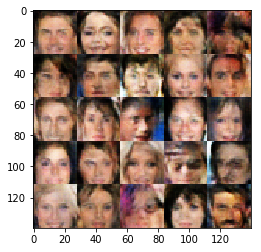

Epoch: 1/1  Discriminator Loss: 1.4647   Generator Loss: 0.4686   
Epoch: 1/1  Discriminator Loss: 1.9530   Generator Loss: 0.2395   
Epoch: 1/1  Discriminator Loss: 1.7510   Generator Loss: 0.3211   
Epoch: 1/1  Discriminator Loss: 2.0338   Generator Loss: 0.2199   
Epoch: 1/1  Discriminator Loss: 1.1711   Generator Loss: 0.7181   


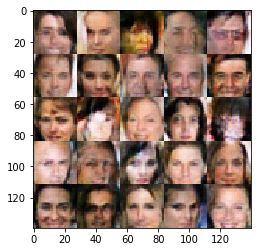

Epoch: 1/1  Discriminator Loss: 1.0861   Generator Loss: 0.9426   
Epoch: 1/1  Discriminator Loss: 1.2111   Generator Loss: 1.0126   
Epoch: 1/1  Discriminator Loss: 1.5463   Generator Loss: 0.3945   
Epoch: 1/1  Discriminator Loss: 1.5425   Generator Loss: 0.3924   
Epoch: 1/1  Discriminator Loss: 1.0801   Generator Loss: 1.0790   


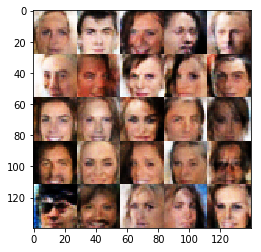

Epoch: 1/1  Discriminator Loss: 1.4743   Generator Loss: 0.4530   
Epoch: 1/1  Discriminator Loss: 1.1782   Generator Loss: 0.6975   
Epoch: 1/1  Discriminator Loss: 1.8287   Generator Loss: 0.2752   
Epoch: 1/1  Discriminator Loss: 1.7882   Generator Loss: 2.2009   
Epoch: 1/1  Discriminator Loss: 1.1767   Generator Loss: 0.7902   


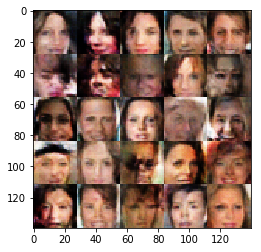

Epoch: 1/1  Discriminator Loss: 1.1184   Generator Loss: 1.1460   
Epoch: 1/1  Discriminator Loss: 1.6943   Generator Loss: 0.3405   
Epoch: 1/1  Discriminator Loss: 1.2168   Generator Loss: 0.8436   
Epoch: 1/1  Discriminator Loss: 1.0687   Generator Loss: 0.8026   
Epoch: 1/1  Discriminator Loss: 1.0705   Generator Loss: 1.3072   


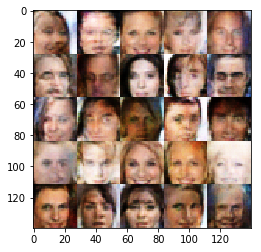

Epoch: 1/1  Discriminator Loss: 1.0911   Generator Loss: 1.9995   
Epoch: 1/1  Discriminator Loss: 1.2840   Generator Loss: 0.6100   
Epoch: 1/1  Discriminator Loss: 1.3533   Generator Loss: 0.5233   
Epoch: 1/1  Discriminator Loss: 1.2642   Generator Loss: 0.7267   
Epoch: 1/1  Discriminator Loss: 1.4143   Generator Loss: 0.4644   


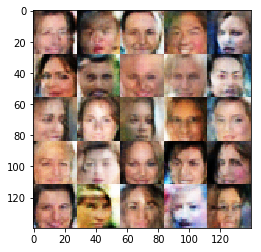

Epoch: 1/1  Discriminator Loss: 1.0859   Generator Loss: 0.7673   
Epoch: 1/1  Discriminator Loss: 1.7272   Generator Loss: 0.3181   
Epoch: 1/1  Discriminator Loss: 1.6048   Generator Loss: 0.3634   
Epoch: 1/1  Discriminator Loss: 1.2710   Generator Loss: 0.7246   
Epoch: 1/1  Discriminator Loss: 1.4194   Generator Loss: 0.4780   


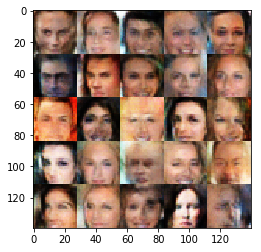

Epoch: 1/1  Discriminator Loss: 1.3142   Generator Loss: 0.6119   
Epoch: 1/1  Discriminator Loss: 1.5116   Generator Loss: 0.4502   
Epoch: 1/1  Discriminator Loss: 1.8336   Generator Loss: 0.2782   
Epoch: 1/1  Discriminator Loss: 1.5632   Generator Loss: 0.4103   
Epoch: 1/1  Discriminator Loss: 1.8039   Generator Loss: 0.3305   


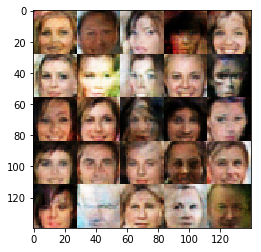

Epoch: 1/1  Discriminator Loss: 0.9122   Generator Loss: 1.0873   
Epoch: 1/1  Discriminator Loss: 1.1919   Generator Loss: 1.1079   
Epoch: 1/1  Discriminator Loss: 1.1241   Generator Loss: 1.3251   
Epoch: 1/1  Discriminator Loss: 0.9362   Generator Loss: 0.8797   
Epoch: 1/1  Discriminator Loss: 1.1655   Generator Loss: 0.6920   


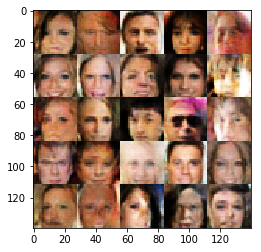

Epoch: 1/1  Discriminator Loss: 1.4707   Generator Loss: 0.4651   
Epoch: 1/1  Discriminator Loss: 1.3183   Generator Loss: 0.5877   
Epoch: 1/1  Discriminator Loss: 1.5179   Generator Loss: 0.4072   
Epoch: 1/1  Discriminator Loss: 1.1711   Generator Loss: 0.6324   
Epoch: 1/1  Discriminator Loss: 1.3637   Generator Loss: 1.0628   


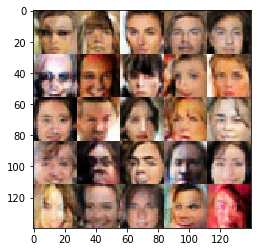

Epoch: 1/1  Discriminator Loss: 1.1567   Generator Loss: 1.1062   
Epoch: 1/1  Discriminator Loss: 1.3803   Generator Loss: 0.5020   
Epoch: 1/1  Discriminator Loss: 1.1630   Generator Loss: 0.7377   
Epoch: 1/1  Discriminator Loss: 1.0455   Generator Loss: 0.9347   
Epoch: 1/1  Discriminator Loss: 1.1283   Generator Loss: 1.4316   


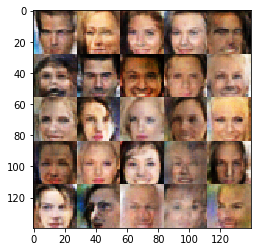

Epoch: 1/1  Discriminator Loss: 1.1999   Generator Loss: 0.6538   
Epoch: 1/1  Discriminator Loss: 1.1591   Generator Loss: 0.7529   
Epoch: 1/1  Discriminator Loss: 1.5554   Generator Loss: 0.4298   
Epoch: 1/1  Discriminator Loss: 1.3722   Generator Loss: 1.5043   
Epoch: 1/1  Discriminator Loss: 1.5151   Generator Loss: 0.3997   


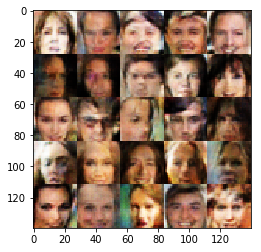

Epoch: 1/1  Discriminator Loss: 1.3491   Generator Loss: 0.5054   
Epoch: 1/1  Discriminator Loss: 0.9842   Generator Loss: 1.1459   
Epoch: 1/1  Discriminator Loss: 1.4896   Generator Loss: 1.2875   
Epoch: 1/1  Discriminator Loss: 1.3541   Generator Loss: 0.5359   
Epoch: 1/1  Discriminator Loss: 1.6787   Generator Loss: 0.3207   


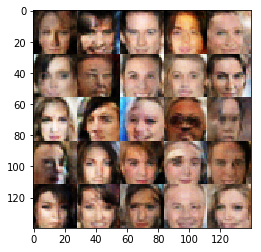

Epoch: 1/1  Discriminator Loss: 1.6238   Generator Loss: 0.3505   
Epoch: 1/1  Discriminator Loss: 2.2674   Generator Loss: 0.1713   
Epoch: 1/1  Discriminator Loss: 1.0404   Generator Loss: 0.9169   
Epoch: 1/1  Discriminator Loss: 1.4969   Generator Loss: 0.4258   
Epoch: 1/1  Discriminator Loss: 1.0874   Generator Loss: 0.8344   


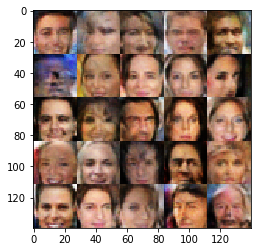

Epoch: 1/1  Discriminator Loss: 1.3927   Generator Loss: 0.4849   
Epoch: 1/1  Discriminator Loss: 1.3208   Generator Loss: 0.5156   
Epoch: 1/1  Discriminator Loss: 1.1254   Generator Loss: 0.7555   
Epoch: 1/1  Discriminator Loss: 1.2251   Generator Loss: 0.6806   
Epoch: 1/1  Discriminator Loss: 1.5291   Generator Loss: 0.4124   


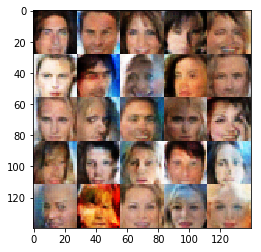

Epoch: 1/1  Discriminator Loss: 0.9237   Generator Loss: 1.1596   
Epoch: 1/1  Discriminator Loss: 1.6686   Generator Loss: 0.3614   
Epoch: 1/1  Discriminator Loss: 1.2772   Generator Loss: 2.1374   
Epoch: 1/1  Discriminator Loss: 1.6541   Generator Loss: 0.3365   
Epoch: 1/1  Discriminator Loss: 1.1384   Generator Loss: 1.1222   


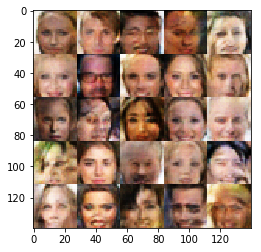

Epoch: 1/1  Discriminator Loss: 1.4477   Generator Loss: 0.4509   
Epoch: 1/1  Discriminator Loss: 2.4126   Generator Loss: 0.1820   
Epoch: 1/1  Discriminator Loss: 1.2144   Generator Loss: 0.6978   
Epoch: 1/1  Discriminator Loss: 1.1297   Generator Loss: 1.0877   
Epoch: 1/1  Discriminator Loss: 1.3982   Generator Loss: 0.5315   


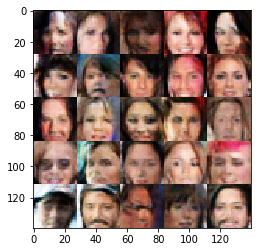

Epoch: 1/1  Discriminator Loss: 1.1693   Generator Loss: 1.7017   
Epoch: 1/1  Discriminator Loss: 1.5087   Generator Loss: 0.4121   
Epoch: 1/1  Discriminator Loss: 1.2678   Generator Loss: 0.5651   
Epoch: 1/1  Discriminator Loss: 0.9441   Generator Loss: 1.9572   
Epoch: 1/1  Discriminator Loss: 0.7031   Generator Loss: 1.3272   


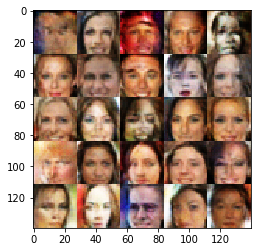

Epoch: 1/1  Discriminator Loss: 1.3053   Generator Loss: 0.5380   
Epoch: 1/1  Discriminator Loss: 1.1372   Generator Loss: 0.7457   
Epoch: 1/1  Discriminator Loss: 1.0909   Generator Loss: 0.9431   
Epoch: 1/1  Discriminator Loss: 1.1047   Generator Loss: 0.6958   
Epoch: 1/1  Discriminator Loss: 1.3240   Generator Loss: 0.5151   


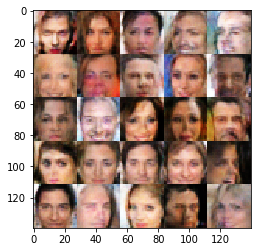

Epoch: 1/1  Discriminator Loss: 1.3597   Generator Loss: 0.5065   
Epoch: 1/1  Discriminator Loss: 1.1775   Generator Loss: 0.8230   
Epoch: 1/1  Discriminator Loss: 0.9029   Generator Loss: 1.0886   
Epoch: 1/1  Discriminator Loss: 1.1076   Generator Loss: 0.7527   
Epoch: 1/1  Discriminator Loss: 1.7421   Generator Loss: 0.3139   


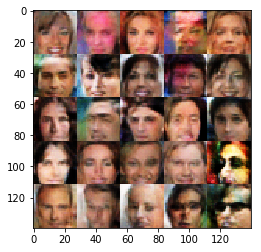

Epoch: 1/1  Discriminator Loss: 1.2321   Generator Loss: 1.4343   
Epoch: 1/1  Discriminator Loss: 1.3595   Generator Loss: 0.5352   
Epoch: 1/1  Discriminator Loss: 1.1421   Generator Loss: 1.0502   
Epoch: 1/1  Discriminator Loss: 1.2474   Generator Loss: 0.6570   
Epoch: 1/1  Discriminator Loss: 0.6794   Generator Loss: 1.4905   


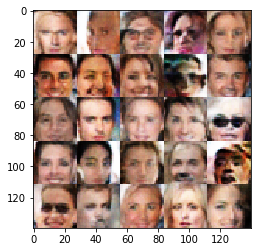

Epoch: 1/1  Discriminator Loss: 0.8079   Generator Loss: 1.3608   
Epoch: 1/1  Discriminator Loss: 1.0839   Generator Loss: 0.6955   
Epoch: 1/1  Discriminator Loss: 1.3841   Generator Loss: 0.4853   
Epoch: 1/1  Discriminator Loss: 1.1939   Generator Loss: 0.7962   
Epoch: 1/1  Discriminator Loss: 2.3176   Generator Loss: 0.1861   


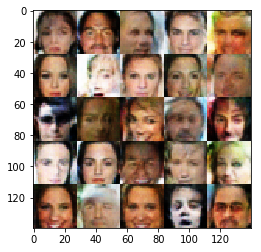

Epoch: 1/1  Discriminator Loss: 1.1966   Generator Loss: 0.5997   
Epoch: 1/1  Discriminator Loss: 1.1035   Generator Loss: 0.6558   
Epoch: 1/1  Discriminator Loss: 1.2045   Generator Loss: 0.6616   
Epoch: 1/1  Discriminator Loss: 1.4893   Generator Loss: 0.4147   
Epoch: 1/1  Discriminator Loss: 1.6313   Generator Loss: 0.3588   


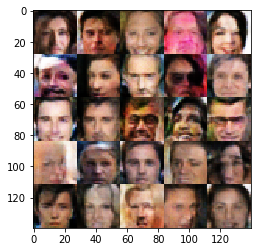

Epoch: 1/1  Discriminator Loss: 1.0687   Generator Loss: 0.8494   
Epoch: 1/1  Discriminator Loss: 1.2543   Generator Loss: 0.7212   
Epoch: 1/1  Discriminator Loss: 1.1623   Generator Loss: 0.6650   
Epoch: 1/1  Discriminator Loss: 1.2984   Generator Loss: 0.6283   
Epoch: 1/1  Discriminator Loss: 1.4477   Generator Loss: 0.5032   


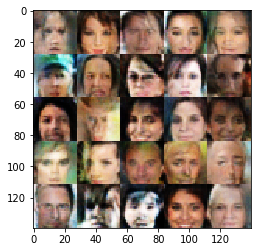

Epoch: 1/1  Discriminator Loss: 1.0672   Generator Loss: 0.9199   
Epoch: 1/1  Discriminator Loss: 1.1928   Generator Loss: 0.7765   
Epoch: 1/1  Discriminator Loss: 1.3646   Generator Loss: 0.5425   
Epoch: 1/1  Discriminator Loss: 1.6117   Generator Loss: 2.1789   
Epoch: 1/1  Discriminator Loss: 1.3199   Generator Loss: 0.6216   


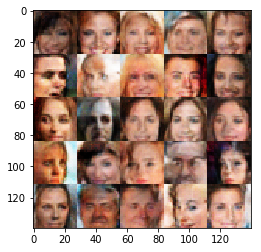

Epoch: 1/1  Discriminator Loss: 0.9507   Generator Loss: 0.9867   
Epoch: 1/1  Discriminator Loss: 1.1254   Generator Loss: 0.8165   
Epoch: 1/1  Discriminator Loss: 2.0561   Generator Loss: 0.2398   
Epoch: 1/1  Discriminator Loss: 1.6029   Generator Loss: 0.3712   
Epoch: 1/1  Discriminator Loss: 1.0073   Generator Loss: 0.8052   


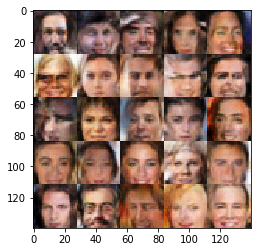

Epoch: 1/1  Discriminator Loss: 0.6833   Generator Loss: 1.5441   
Epoch: 1/1  Discriminator Loss: 1.4818   Generator Loss: 0.4546   
Epoch: 1/1  Discriminator Loss: 1.1111   Generator Loss: 0.7478   
Epoch: 1/1  Discriminator Loss: 0.9348   Generator Loss: 1.3370   
Epoch: 1/1  Discriminator Loss: 1.7706   Generator Loss: 0.3071   


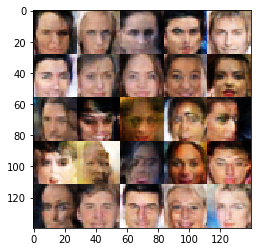

Epoch: 1/1  Discriminator Loss: 1.8354   Generator Loss: 0.3022   
Epoch: 1/1  Discriminator Loss: 1.3898   Generator Loss: 0.4879   
Epoch: 1/1  Discriminator Loss: 1.0784   Generator Loss: 0.8197   
Epoch: 1/1  Discriminator Loss: 1.6046   Generator Loss: 0.4122   
Epoch: 1/1  Discriminator Loss: 1.5418   Generator Loss: 0.4498   


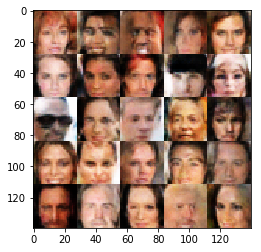

Epoch: 1/1  Discriminator Loss: 1.4842   Generator Loss: 0.4228   


In [35]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.